In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA

In [2]:
# Cчитывание и подготовка данных
data = pd.read_csv('adult.csv')
columns4normolize=data[:]
columns4normolize.drop(['workclass','educational-num','education','native-country','marital-status','occupation','relationship','race','gender','income'], axis=1, inplace=True)
data["income"] = data.income.replace({"<=50K": 0, ">50K":1})
data["gender"] = data.gender.replace({"Female": 0, "Male":1})
data.drop(["educational-num"], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['workclass','education','native-country','marital-status','occupation','relationship','race'])
y = data.income
X = data.drop('income', axis=1)
scaler = StandardScaler()
scaler.fit(columns4normolize)
X_scaled = scaler.transform(columns4normolize)
X_scaled = pd.DataFrame(X_scaled, columns=columns4normolize.columns)
for col in columns4normolize.columns:
    X[col]=X_scaled[col]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [3]:
# Функция оценки качества построения дерева решений для разбиении на k главных компанент.
def calc_rezult(X,y,trn_ix,tst_ix,k):
    pca=PCA(n_components=k)
    X2 = pca.fit_transform(X)
    model = LogisticRegression()
    model.fit( X2[trn_ix], y[trn_ix] )
    y_pred = model.predict(X2[tst_ix])
    return [accuracy(y[tst_ix], y_pred), precision(y[tst_ix], y_pred), recall(y[tst_ix], y_pred)]

In [4]:
# Деление на тестовую и обучающую выборки
sss = ShuffleSplit(n_splits=1, test_size=0.2)
sss.get_n_splits(X, y)
trn_ix, tst_ix = next(sss.split(X, y)) 

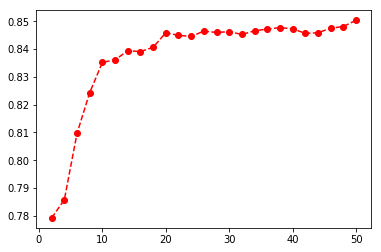

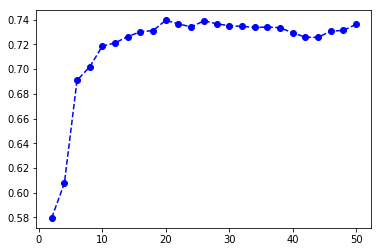

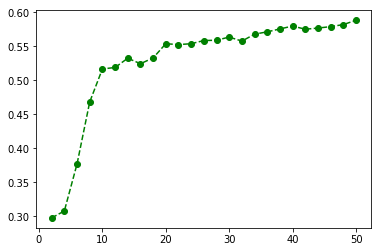

In [5]:
# Так как количиство фичей большое (106) проведем простой анализ МГК
x_exp=np.arange(2,int(X.shape[1]/2)-1,2);
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0;
for i in x_exp:
    y_exp[0][k] , y_exp[1][k] , y_exp[2][k] =calc_rezult(X,y,trn_ix,tst_ix,x_exp[k])
    k=k+1;
y_exp    
plt.plot(x_exp,y_exp[0],'ro--')
plt.show()
plt.plot(x_exp,y_exp[1],'bo--')
plt.show()
plt.plot(x_exp,y_exp[2],'go--')
plt.show()

In [6]:
# Как можно видеть, примерно после 30 компонент не происходит значительного прироста качества, потому остановимся на 30-ГК.
pca=PCA(n_components=30)
X2 = pca.fit_transform(X)
model = LogisticRegression()
model.fit( X2[trn_ix], y[trn_ix] )
y_pred = model.predict(X2[tst_ix])

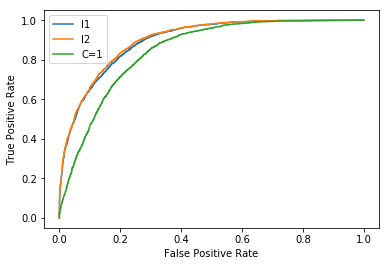

In [7]:
# Построим ROC кривые для 3х случаев регуляризации.
model1 = LogisticRegression( penalty = 'l1', C = 0.01 ).fit( X2[trn_ix], y[trn_ix] )
predictions1 = model1.predict_proba( X2[tst_ix] )
model1 = LogisticRegression( penalty = 'l2', C = 0.01 ).fit( X2[trn_ix], y[trn_ix] )
predictions2 = model1.predict_proba( X2[tst_ix] )
model1 = LogisticRegression( penalty = 'l1', C = 0.001 ).fit( X2[trn_ix], y[trn_ix] )
predictions3 = model1.predict_proba( X2[tst_ix] )
fpr1, tpr1, thres1 = roc_curve( y[tst_ix], predictions1[:, 1] )
fpr2, tpr2, thres2 = roc_curve( y[tst_ix], predictions2[:, 1] )
fpr3, tpr3, thres3 = roc_curve( y[tst_ix], predictions3[:, 1] )
plt.plot( fpr1, tpr1, label = 'l1' )
plt.plot( fpr2, tpr2, label = 'l2' )
plt.plot( fpr3, tpr3, label = 'C=1' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()